In [1]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [3]:
maf = 0.91 # allele frequency
N = 30000 # pop size
beta = 0.42 # beta of effect (0.42 in Nemuna's, 0.04 in A. Johnson... for PEAR1) 
R_2 = 0.03 # estimated R^2 of prediction
R_2_measure = 0.8 # If we do the measure twice for an individual, the R^2 is 0.8

In [4]:
# le phénotype, mesuré avec R_2 = 0.8, a un beta = -0.06

In [5]:
def get_p_value(N, beta, R_2, maf, R_2_measure = 1.):
    
    beta = beta / np.sqrt(R_2_measure)
    rho = np.sqrt(R_2)
    rho_measure = np.sqrt(R_2_measure)
    
    G = np.stack([np.random.choice([0,1],N,p=[1-maf,maf]),np.random.choice([0,1],N,p=[1-maf,maf])],axis=1)
    G = np.mean(G,axis=1)
    G -= np.mean(G)
    G /= np.std(G)

    y_true = G*beta + (1-beta**2)*np.random.normal(0,1,N)
    y_measured = y_true*rho_measure + (1-rho_measure**2)*np.random.normal(0,1,N)
    y_hat = y_measured*rho + (1-rho**2)*np.random.normal(0,1,N)
    
    _, p_hat = pearsonr(y_hat,G)
    return p_hat

In [12]:
N_tests = 50

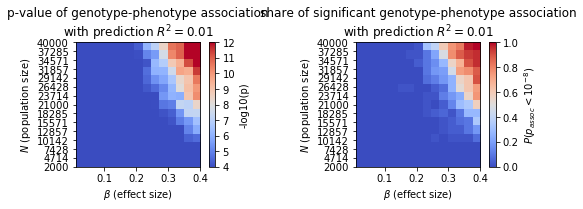

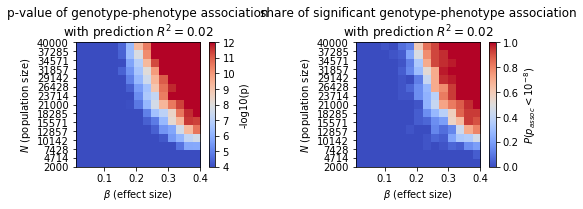

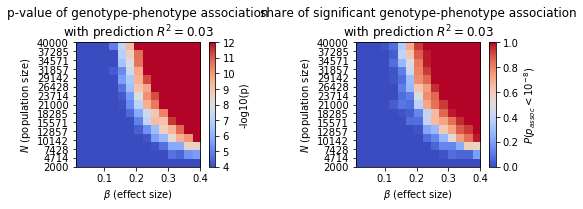

In [13]:
for R_2 in [0.01,0.02,0.03]:

    n_pop_size = 15
    n_betas = 15
    p_values = np.zeros((n_pop_size,n_betas))
    is_hit = np.zeros((n_pop_size,n_betas))
    pop_size = np.linspace(2000,40000,n_pop_size,dtype=int)
    betas = np.linspace(0.01,0.4,n_betas,endpoint=True)
    for i, N in enumerate(pop_size):
        for j, beta in enumerate(betas):
            p_vals = np.array([get_p_value(N,beta,R_2,maf,R_2_measure) for _ in range(N_tests)])
            p_values[i,j] = np.median(p_vals)
            is_hit[i,j] = np.mean(p_vals < 1e-8)

    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(121)
    cb = ax.imshow(-np.log10(p_values),origin="lower",
                   extent=[betas[0],betas[-1],pop_size[0],pop_size[-1]],
                   cmap="coolwarm",norm=mcolors.DivergingNorm(vcenter=8,vmin=4,vmax=12))
    ax.set_aspect((betas[0]-betas[-1])/(pop_size[0]-pop_size[-1]))
    plt.colorbar(cb,label="-log10(p)")
    plt.yticks(pop_size)
    plt.ylabel("$N$ (population size)")
    plt.xlabel("$\\beta$ (effect size)")
    plt.title("p-value of genotype-phenotype association\nwith prediction $R^2 = %.2f$" % R_2)
    
    ax = fig.add_subplot(122)
    cb = ax.imshow(is_hit,origin="lower",
                   extent=[betas[0],betas[-1],pop_size[0],pop_size[-1]],
                   cmap="coolwarm",norm=mcolors.Normalize(vmin=0,vmax=1))
    ax.set_aspect((betas[0]-betas[-1])/(pop_size[0]-pop_size[-1]))
    plt.colorbar(cb,label="$P(p_{assoc} < 10^{-8})$")
    plt.yticks(pop_size)
    plt.ylabel("$N$ (population size)")
    plt.xlabel("$\\beta$ (effect size)")
    plt.title("share of significant genotype-phenotype association\nwith prediction $R^2 = %.2f$" % R_2)
    plt.tight_layout()